In [ ]:
install.packages("Seurat")
packageVersion("Seurat")

In [ ]:
library(dplyr)
library(patchwork)
library(Seurat)
library(ggplot2)                  
library(igraph)

In [7]:
options(stringsAsFactors = FALSE)

In [ ]:
data_dir <- "GSM4306638"
list.files(data_dir)
expression_matrix <- Read10X(data.dir = data_dir)
seurat_object <- CreateSeuratObject(counts = expression_matrix,min.cells = 5,min.features = 500)

In [ ]:
head(seurat_object)

In [ ]:
seurat_object[["percent.mt"]] <- PercentageFeatureSet(seurat_object, pattern = "^mt-")
VlnPlot(seurat_object,features = c("nFeature_RNA","nCount_RNA","percent.mt"),ncol = 3)

In [ ]:
seurat_object <- subset(seurat_object, subset =  percent.mt < 5)

In [ ]:
seurat_object <- NormalizeData(seurat_object,normalization.method = "LogNormalize",scale.factor = 10000)

In [ ]:
# Detection of highly variable genes
seurat_object <- FindVariableFeatures(seurat_object, selection.method = "vst", nfeatures = 2000)

# Identify the 10 most highly variable genes
top10 <- head(VariableFeatures(seurat_object), 10)

# plot variable features with and without labels
plot1 <- VariableFeaturePlot(seurat_object)
plot2 <- LabelPoints(plot = plot1, points = top10, repel = TRUE)
plot2

In [ ]:
all.genes <- rownames(seurat_object)
# Data scaling
seurat_object <- ScaleData(seurat_object, features = all.genes)

In [ ]:
seurat_object <- RunPCA(seurat_object, features = VariableFeatures(object = seurat_object))

In [ ]:
# NOTE: This process can take a long time for big datasets, comment out for expediency. More
# approximate techniques such as those implemented in ElbowPlot() can be used to reduce
# computation time
seurat_object <- JackStraw(seurat_object, num.replicate = 100)
seurat_object <- ScoreJackStraw(seurat_object, dims = 1:20)

In [ ]:
seurat_object <- FindNeighbors(seurat_object,dims = 1:50)
seurat_object1 <- FindClusters(seurat_object, resolution = 1)

In [ ]:
seurat_object1 <- RunUMAP(seurat_object1, dims = 1:50)

In [ ]:
DimPlot(seurat_object1,reduction = "umap",label = T,group.by = "seurat_clusters")

In [ ]:
# find markers for every cluster compared to all remaining cells, report only the positive
# ones
cl.markers <- FindAllMarkers(seurat_object1, only.pos = TRUE, min.pct = 0.25, logfc.threshold = 0.25)
cl.markers %>%
    group_by(cluster) %>%
    slice_max(n = 10, order_by = avg_log2FC)

In [25]:
write.csv(cl.markers,"top10_markers.csv")

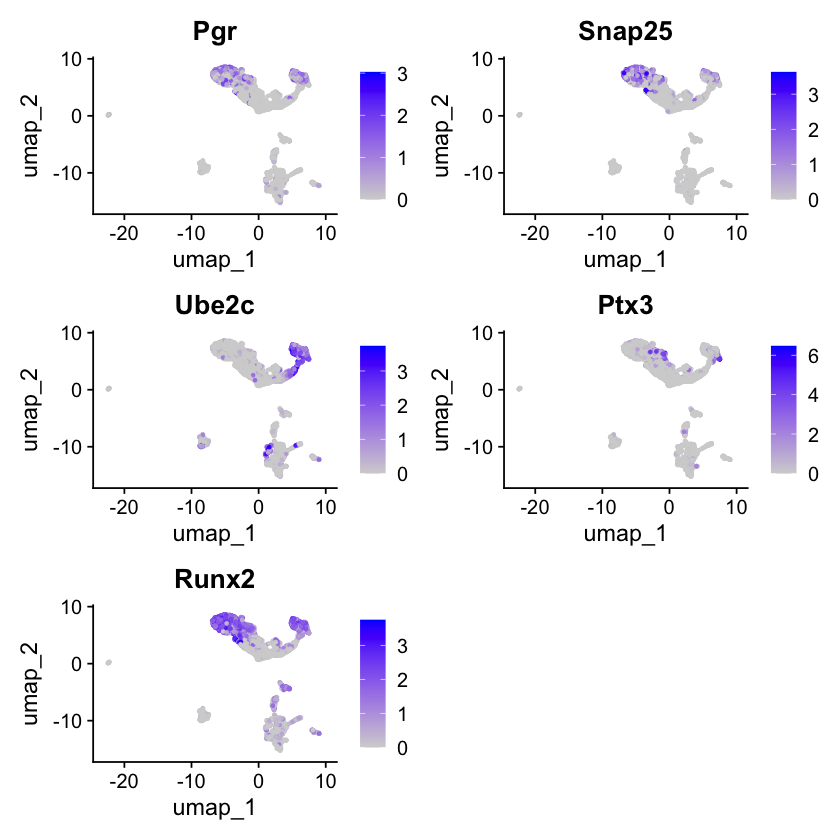

In [34]:
FeaturePlot(seurat_object1, features = c("Snap25","Ube2c"))

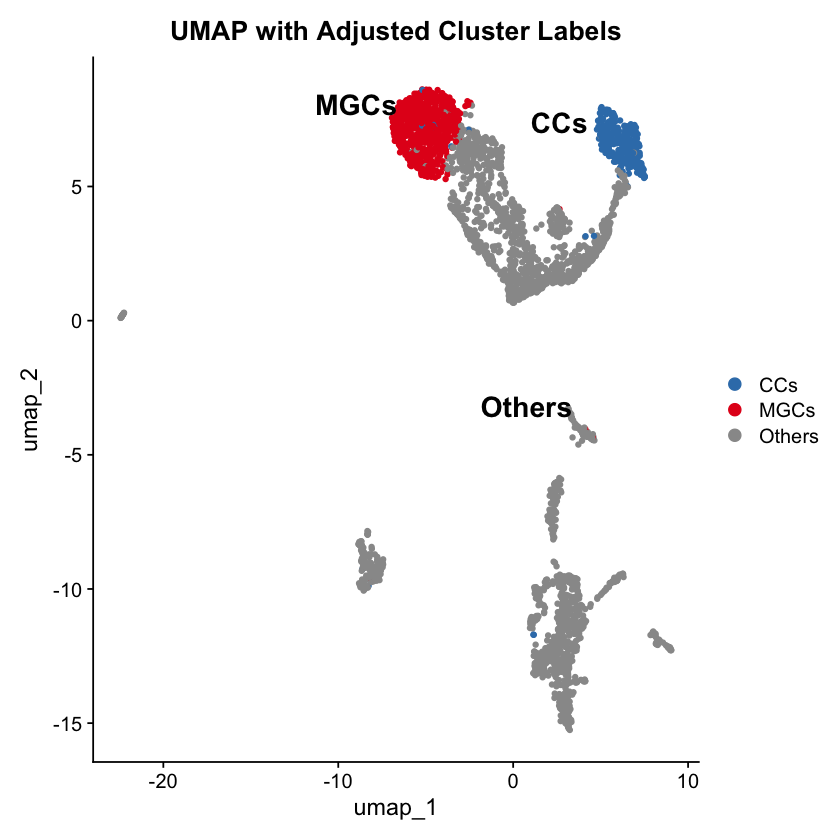

In [45]:
#. 0 ovulatory GC (Snap25), 2 ovulatory CC (Ube2c)
# Convert cluster numbers into new cell type labels
new_cluster_ids <- as.character(Idents(seurat_object1))  # Retrieve current cluster IDs
new_cluster_ids[new_cluster_ids == "0"] <- "MGCs"       # Cluster 0 → MGCs
new_cluster_ids[new_cluster_ids == "2"] <- "CCs"        # Cluster 2 → CCs
new_cluster_ids[!new_cluster_ids %in% c("MGCs", "CCs")] <- "Others"  # All other clusters → Others

# Add the new cell type information into metadata
seurat_object1$cell_type <- new_cluster_ids

# Set Idents to the new cell type labels
Idents(seurat_object1) <- seurat_object1$cell_type

# Define colors (customize if needed)
colors <- c("MGCs" = "#E41A1C", "CCs" = "#377EB8", "Others" = "#999999")

# UMAP plot (without labels)
umap_plot <- DimPlot(seurat_object1, group.by = "cell_type", cols = colors, label = FALSE, pt.size = 1)

# Extract UMAP coordinates and cell_type information (converted to lowercase automatically by Seurat)
umap_data <- FetchData(seurat_object1, vars = c("umap_1", "umap_2", "cell_type"))

# Calculate the centroid (mean coordinates) for each cell type
centroids <- aggregate(cbind(umap_1, umap_2) ~ cell_type, data = umap_data, FUN = mean)

# Add offsets for label positions (adjusted only for MGCs and CCs)
centroids$umap_1_offset <- centroids$umap_1
centroids$umap_2_offset <- centroids$umap_2

# Offset the label position for MGCs (shift to upper right)
centroids$umap_1_offset[centroids$cell_type == "MGCs"] <- centroids$umap_1[centroids$cell_type == "MGCs"] - 4
centroids$umap_2_offset[centroids$cell_type == "MGCs"] <- centroids$umap_2[centroids$cell_type == "MGCs"] + 1

# Offset the label position for CCs (shift to upper left)
centroids$umap_1_offset[centroids$cell_type == "CCs"] <- centroids$umap_1[centroids$cell_type == "CCs"] - 3
centroids$umap_2_offset[centroids$cell_type == "CCs"] <- centroids$umap_2[centroids$cell_type == "CCs"] + 1

# Others remain unchanged (can be adjusted if needed)

# UMAP plot with adjusted cluster labels
umap_plot +
  geom_text(data = centroids, aes(x = umap_1_offset, y = umap_2_offset, label = cell_type),
            color = "black", size = 6, fontface = "bold", hjust = 0.5) +
  ggtitle("UMAP with Adjusted Cluster Labels")


In [46]:
table(seurat_object1$cell_type)



   CCs   MGCs Others 
   312    680   2119 